# Set up

In [1]:
train_path = 'leaf_data_tomato/train'
valid_path = 'leaf_data_tomato/valid'
test_path = 'leaf_data_tomato/test'

In [ ]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.optimizers import Adadelta
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import operator
%matplotlib inline

C:\Users\NICK\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense
from keras import applications

In [45]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop

ModuleNotFoundError: No module named 'tensorflow.python.keras'

In [46]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['c_28','c_30','c_32'], batch_size=15)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['c_28','c_30','c_32'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['c_28','c_30','c_32'], batch_size=50)

Found 1620 images belonging to 3 classes.
Found 390 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [47]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
imgs, labels = next(train_batches)

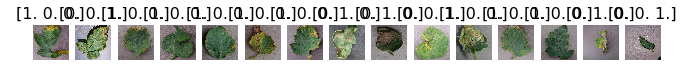

In [50]:
plots(imgs, titles=labels)

In [51]:
img_width,img_height = 224,224

In [52]:
#batch_size = 10

In [53]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [54]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [55]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [56]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=15,
   class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    batch_size=10,
    class_mode='categorical'
)


Found 1620 images belonging to 3 classes.
Found 390 images belonging to 3 classes.


# Build and train CNN

## Build Fine-tuned VGG16 model

In [57]:
#vgg16_model = keras.applications.vgg16.VGG16()
#model = VGG16(include_top=True, weights='imagenet')
model = applications.VGG16(weights='imagenet')

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [59]:
model.layers.pop()
model.layers.pop()
model.layers.pop()


In [60]:
model.layers.pop()

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [62]:
transfer_layer = model.get_layer('block5_pool')

In [63]:
transfer_layer.output

<tf.Tensor 'block5_pool_1/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [64]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [66]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(3, activation='softmax'))

In [67]:
conv_model.save_weights('finetune_VGG_conv_model_wights.h5')

In [68]:
###   function for printing the booleans of trainability 

In [69]:

def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [70]:
print_layer_trainable()

False:	input_2
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [71]:
##### set trainability = false 

In [72]:
#conv_model.trainable = False

In [73]:
#for layer in conv_model.layers:
 #   layer.trainable = False

In [74]:
print_layer_trainable()

False:	input_2
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [75]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3075      
Total params: 40,408,899
Trainable params: 40,408,899
Non-trainable params: 0
_________________________________________________________________


In [76]:
for layer in new_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

True:	model_2
True:	flatten_3
True:	dense_5
True:	dropout_3
True:	dense_6


In [80]:
new_model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
#Adam(lr=1e-5)  next try this 

## Train the fine-tuned VGG16 model

In [81]:
#model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
new_model.fit_generator(train_generator, steps_per_epoch=108, 
                    validation_data=validation_generator, validation_steps=39, epochs=5, verbose=2)

Epoch 1/5
 - 5475s - loss: 0.6611 - acc: 0.7179 - val_loss: 0.2391 - val_acc: 0.8974
Epoch 2/5
 - 5388s - loss: 0.2338 - acc: 0.9130 - val_loss: 0.0968 - val_acc: 0.9564
Epoch 3/5
 - 5367s - loss: 0.1366 - acc: 0.9444 - val_loss: 0.0625 - val_acc: 0.9769
Epoch 4/5


###### old model results
#model.fit_generator(train_batches, steps_per_epoch=4, 
#                    validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

## Predict using fine-tuned VGG16 model

In [ ]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [ ]:
#test_labels = test_labels[:,0]
test_labels

In [ ]:
new_model.save_weights('finetune_VGG.h5')

In [ ]:
predictions = new_model.predict_generator(test_batches, steps=1, verbose=0)

In [ ]:
#headHM   Saving model
predictions

In [ ]:
new_model.save_weights('finetune_VGG.h5')

In [ ]:
ar = np.zeros((50,), dtype=np.int)

In [ ]:
for x in range(50):
    max_index, max_value = max(enumerate(predictions[[x]].ravel()), key=operator.itemgetter(1))   
    ar[x] = max_index

In [ ]:
ar_test = np.zeros((50,), dtype=np.int)

In [ ]:
for x in range(50):
    max_index, max_value = max(enumerate(test_labels[[x]].ravel()), key=operator.itemgetter(1))   
    ar_test[x] = max_index

In [ ]:
#cm = confusion_matrix(test_labels, np.round(predictions[:,0]))
cm = confusion_matrix(ar_test, ar)

In [ ]:

cm_plot_labels = ['c_3','c_4','c_5']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
#old model results
cm_plot_labels = ['c_3','c_4','c_5']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')